# Site Energy Intensity Prediction


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

**🧾Description**: According to a report issued by the International Energy Agency (IEA), the lifecycle of buildings from construction to demolition was responsible for 37% of global energy-related and process-related CO2(Carbon Dioxide) emissions in 2020. Yet it is possible to drastically reduce the energy consumption of buildings by a combination of easy-to-implement fixes and state-of-the-art strategies. 

🧭 **Problem Statement:** You are provided with two datasets:
1. the train\_dataset where the observed values of the Site EUI for each row are provided and,
2. the x\_test dataset the observed values of the Site EUI for each row are removed and provided separately in y\_test. 

Your task is to predict the Site EUI for each row (using the complete training dataset), given the characteristics of the building and the weather data for the location of the building. Use the test sets for validation and testing. 

The target variable is **site\_eui** and the evaluation metric is **RMSE** score.


## Importing Libraries

In [ ]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 7.2 MB/s 


In [ ]:
!pip install pickle5 --quiet

     |████████████████████████████████| 256 kB 29.7 MB/s 


In [ ]:
!pip install catboost --quiet

     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 34.7 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import pickle5 as pickle
import tqdm
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder,LabelEncoder
from category_encoders import TargetEncoder
import shap

from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
#from fancyimpute import KNN
sns.set()

## Importing Data

In [ ]:
train=pd.read_csv("/content/drive/MyDrive/Site_Energy_Intensity_Prediction/Dataset/train_dataset.csv")
test=pd.read_csv("/content/drive/MyDrive/Site_Energy_Intensity_Prediction/Dataset/x_test.csv")

In [ ]:
train_data=train.copy()
test_data=test.copy()
print(f"Train Data Shape:{train_data.shape}\nTest Data Shape:{test_data.shape}")

Train Data Shape:(75757, 64)
Test Data Shape:(9705, 63)


In [ ]:
train_data.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,248.682615,0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,26.500150,1
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,24.693619,2
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,48.406926,3
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,3.899395,4


In [ ]:
train_data.columns

Index(['Year_Factor', 'State_Factor', 'building_class', 'facility_type',
       'floor_area', 'year_built', 'energy_star_rating', 'ELEVATION',
       'january_min_temp', 'january_avg_temp', 'january_max_temp',
       'february_min_temp', 'february_avg_temp', 'february_max_temp',
       'march_min_temp', 'march_avg_temp', 'march_max_temp', 'april_min_temp',
       'april_avg_temp', 'april_max_temp', 'may_min_temp', 'may_avg_temp',
       'may_max_temp', 'june_min_temp', 'june_avg_temp', 'june_max_temp',
       'july_min_temp', 'july_avg_temp', 'july_max_temp', 'august_min_temp',
       'august_avg_temp', 'august_max_temp', 'september_min_temp',
       'september_avg_temp', 'september_max_temp', 'october_min_temp',
       'october_avg_temp', 'october_max_temp', 'november_min_temp',
       'november_avg_temp', 'november_max_temp', 'december_min_temp',
       'december_avg_temp', 'december_max_temp', 'cooling_degree_days',
       'heating_degree_days', 'precipitation_inches', 'snowfall_inc

In [ ]:
train_data.rename(columns={
    'Year_Factor':'year_factor',
    'State_Factor':'state_factor',
    'ELEVATION':'elevation', 
},inplace=True)
test_data.rename(columns={
    'Year_Factor':'year_factor',
    'State_Factor':'state_factor',
    'ELEVATION':'elevation', 
},inplace=True)

## EDA

**DATA DICTINOARY**

**year_Factor**: anonymized year in which the weather and energy usage factors were observed  

**state_Factor**: anonymized state in which the building is located  

**building_class**: building classification  

**facility_type**: building usage type  

**floor_area**: floor area (in square feet) of the building  

**year_built**: year in which the building was constructed  

**energy_star_rating**: the energy star rating of the building  

**elevation**: elevation of the building location  

**january_min_temp**: minimum temperature in January (in Fahrenheit) at the location of the building  

**january_avg_temp**: average temperature in January (in Fahrenheit) at the location of the building  

**january_max_temp**: maximum temperature in January (in Fahrenheit) at the location of the building  

[Similarly for all other months]

**cooling_degree_days**: cooling degree day for a given day is the number of degrees where the daily average temperature   
exceeds 65 degrees Fahrenheit. Each month is summed to produce an annual total at the location of the building.  

**heating_degree_days**: heating degree day for a given day is the number of degrees where the daily average temperature   falls under 65 degrees Fahrenheit. Each month is summed to produce an annual total at the location of the building.  

**precipitation_inches**: annual precipitation in inches at the location of the building  

**snowfall_inches**: annual snowfall in inches at the location of the building  

**snowdepth_inches**: annual snow depth in inches at the location of the building  

**avg_temp**: average temperature over a year at the location of the building  

**days_below_30F**: total number of days below 30 degrees Fahrenheit at the location of the building  

**days_below_20F**: total number of days below 20 degrees Fahrenheit at the location of the building  

**days_below_10F**: total number of days below 10 degrees Fahrenheit at the location of the building  

**days_below_0F**: total number of days below 0 degrees Fahrenheit at the location of the building  

**days_above_80F**: total number of days above 80 degrees Fahrenheit at the location of the building  

**days_above_90F**: total number of days above 90 degrees Fahrenheit at the location of the building  

**days_above_100F**: total number of days above 100 degrees Fahrenheit at the location of the building  

**days_above_110F**: total number of days above 110 degrees Fahrenheit at the location of the building  

**direction_max_wind_speed**: wind direction for maximum wind speed at the location of the building. Given in 360-degree compass point directions (e.g. 360 = north, 180 = south, etc.).  

**direction_peak_wind_speed**: wind direction for peak wind gust speed at the location of the building. Given in 360-degree compass point directions (e.g. 360 = north, 180 = south, etc.).  

**max_wind_speed**: maximum wind speed at the location of the building  

**days_with_fog**: number of days with fog at the location of the building  

**building_id**: building id  

### Target
**site_eui**: Site Energy Usage Intensity is the amount of heat and electricity consumed by a building as reflected in utility bills  

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75757 entries, 0 to 75756
Data columns (total 64 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   year_factor                75757 non-null  int64  
 1   state_factor               75757 non-null  object 
 2   building_class             75757 non-null  object 
 3   facility_type              75757 non-null  object 
 4   floor_area                 75757 non-null  float64
 5   year_built                 73920 non-null  float64
 6   energy_star_rating         49048 non-null  float64
 7   elevation                  75757 non-null  float64
 8   january_min_temp           75757 non-null  int64  
 9   january_avg_temp           75757 non-null  float64
 10  january_max_temp           75757 non-null  int64  
 11  february_min_temp          75757 non-null  int64  
 12  february_avg_temp          75757 non-null  float64
 13  february_max_temp          75757 non-null  int

In [ ]:
print(train_data.duplicated().sum())
print(test_data.duplicated().sum())

0
0


In [ ]:
def missing_values(df):
  mis_val=df.isnull().sum()
  mis_val_percent=100*df.isnull().sum()/len(df)
  mis_val_table=pd.concat([mis_val,mis_val_percent],axis=1)
  mis_val_table=mis_val_table.rename(columns={0 : 'Missing Values', 1 : '% of Total Values'})
  mis_val_table=mis_val_table[mis_val_table.iloc[:,1]!=0].sort_values('% of Total Values', ascending=False).round(1)
  print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n" +"There are " + str(mis_val_table.shape[0]) +" columns that have missing values.")
  return mis_val_table

In [ ]:
print(f"Train set shape: {train_data.shape}")
print("Train set columns with null values: ")
print(list(train_data.columns[train_data.isnull().any()]))
print("******************************************************")
# Missing Values for Training Data
mis_val_train=missing_values(train_data)
mis_val_train

Train set shape: (75757, 64)
Train set columns with null values: 
['year_built', 'energy_star_rating', 'direction_max_wind_speed', 'direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog']
******************************************************
Your selected dataframe has 64 columns.
There are 6 columns that have missing values.


,Missing Values,% of Total Values
days_with_fog,45796,60.5
direction_peak_wind_speed,41811,55.2
direction_max_wind_speed,41082,54.2
max_wind_speed,41082,54.2
energy_star_rating,26709,35.3
year_built,1837,2.4


### Observation
* 'year_built', 'energy_star_rating', 'direction_max_wind_speed', 'direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog' are the columns with NULL( `NA`) values in training dataset.
* Training Dataset has total 75757 rows and 64 columns.
* There are 6 columns that have missing values.


In [ ]:
print(f"Test set shape: {test_data.shape}")
print("Test set columns with null values: ")
print(list(test_data.columns[test_data.isnull().any()]))
print("******************************************************")
# Missing Values for Training Data
mis_val_test=missing_values(test_data)
mis_val_test

Test set shape: (9705, 63)
Test set columns with null values: 
['year_built', 'energy_star_rating', 'direction_max_wind_speed', 'direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog']
******************************************************
Your selected dataframe has 63 columns.
There are 6 columns that have missing values.


,Missing Values,% of Total Values
days_with_fog,9117,93.9
direction_max_wind_speed,8575,88.4
direction_peak_wind_speed,8575,88.4
max_wind_speed,8575,88.4
energy_star_rating,2254,23.2
year_built,92,0.9


### Observation
* 'year_built', 'energy_star_rating', 'direction_max_wind_speed', 'direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog' are the columns with NULL( `NA`) values in training dataset.
* Training Dataset has total 9705 rows and 63 columns.
* There are 6 columns that have missing values.


In [ ]:
print([col for col in train_data if train_data[col].nunique()==1])
print([col for col in test_data if test_data[col].nunique()==1])

[]
['year_factor', 'days_above_110F']


### Observation
Train dataset has no constant columns and Test Dataset has 2 constant columns.

### Combining the two dataset

In [ ]:
test["site_eui"]=np.nan
test["dataset"]="test"
train["dataset"]="train"

In [ ]:
dataset = pd.concat([train, test], axis=0, ignore_index=True)

In [ ]:
dataset['Year_Factor'].unique()

array([1, 2, 3, 4, 5, 6, 7])

In [ ]:
dataset.shape

(85462, 65)

The dataset contains time variable, `Year_Factor`, that has values from 1 to 7.
Lets see the number of data points in each year and distinguish them on the basis of their dataset i.e train and test respectively.

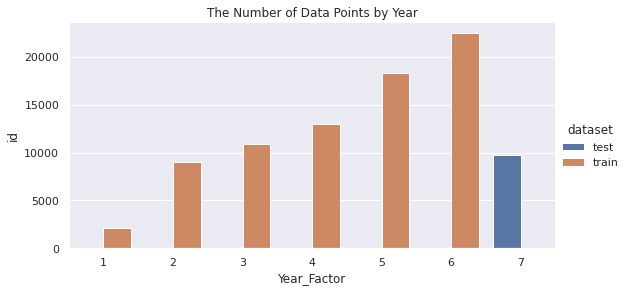

In [ ]:
#Visualising the Year Factor  
sns.catplot(x='Year_Factor', 
            y='id',
            data=dataset.groupby(['dataset','Year_Factor']).agg({'id':'count'}).reset_index(),
            hue='dataset',
            kind='bar',
            aspect=2,
            height=4)
plt.title("The Number of Data Points by Year")
plt.show()

In [ ]:
dataset['State_Factor'].unique()

array(['State_1', 'State_2', 'State_4', 'State_6', 'State_8', 'State_10',
       'State_11'], dtype=object)

`Staet_Factor`, has 7 different states factor which are respectively, State_1, State_2, State_4, State_6, State_8, State_10, State_11.

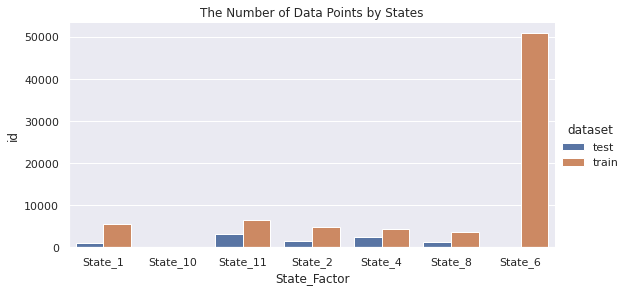

In [ ]:
#Visualising the State Factor 
sns.catplot(x='State_Factor', 
            y='id',
            data=dataset.groupby(['dataset','State_Factor']).agg({'id':'count'}).reset_index(),
            hue='dataset',
            kind='bar',
            aspect=2,
            height=4)
plt.title("The Number of Data Points by States")
plt.show()

Both `test` and `train` dataset have the datapoints in every states. It can be also seen that State 6 contribute majorly to the train data set.

In [ ]:
dataset['building_class'].unique()

array(['Commercial', 'Residential'], dtype=object)

There are two types of Building Residential and Commercial.
Lets see their number in train and test dataset.

Text(0.5, 0, '')

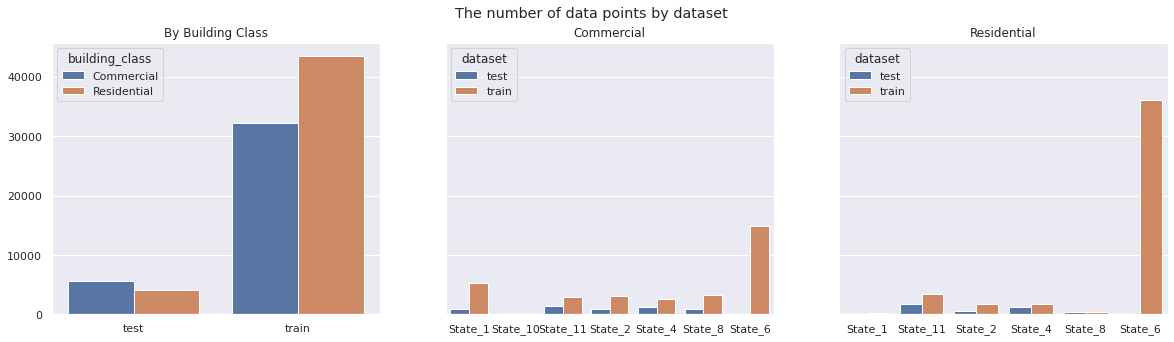

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(20,5), sharey=True)
fig.suptitle("The number of data points by dataset")

sns.barplot(x='dataset',
            y='id',
            data=dataset.groupby(['dataset','building_class']).agg({'id':'count'}).reset_index(),
            hue='building_class',
            ax=ax[0],
            ci=False)

for e,s in enumerate(dataset['building_class'].unique(),1):
  sns.barplot(x='State_Factor',
              y='id',
              data=dataset[dataset['building_class']==s].groupby(['dataset','State_Factor']).agg({'id':'count'}).reset_index(),
              hue='dataset',
              ax=ax[e],
              ci=False)

  ax[e].set_title(s)
  ax[e].set_ylabel("")
  ax[e].set_xlabel("")

ax[0].set_title("By Building Class")
ax[0].set_ylabel("")
ax[0].set_xlabel("")

Number of `Residential` building class is more in train dataset as compared to test dataset.Major contributing factor to it is `State_6` column.

In [ ]:
dataset['facility_type'].unique()

array(['Grocery_store_or_food_market',
       'Warehouse_Distribution_or_Shipping_center',
       'Retail_Enclosed_mall', 'Education_Other_classroom',
       'Warehouse_Nonrefrigerated', 'Warehouse_Selfstorage',
       'Office_Uncategorized', 'Data_Center', 'Commercial_Other',
       'Mixed_Use_Predominantly_Commercial',
       'Office_Medical_non_diagnostic', 'Education_College_or_university',
       'Industrial', 'Laboratory',
       'Public_Assembly_Entertainment_culture',
       'Retail_Vehicle_dealership_showroom', 'Retail_Uncategorized',
       'Lodging_Hotel', 'Retail_Strip_shopping_mall',
       'Education_Uncategorized', 'Health_Care_Inpatient',
       'Public_Assembly_Drama_theater', 'Public_Assembly_Social_meeting',
       'Religious_worship', 'Mixed_Use_Commercial_and_Residential',
       'Office_Bank_or_other_financial', 'Parking_Garage',
       'Commercial_Unknown', 'Service_Vehicle_service_repair_shop',
       'Service_Drycleaning_or_Laundry', 'Public_Assembly_Recreation

<Figure size 1080x504 with 0 Axes>

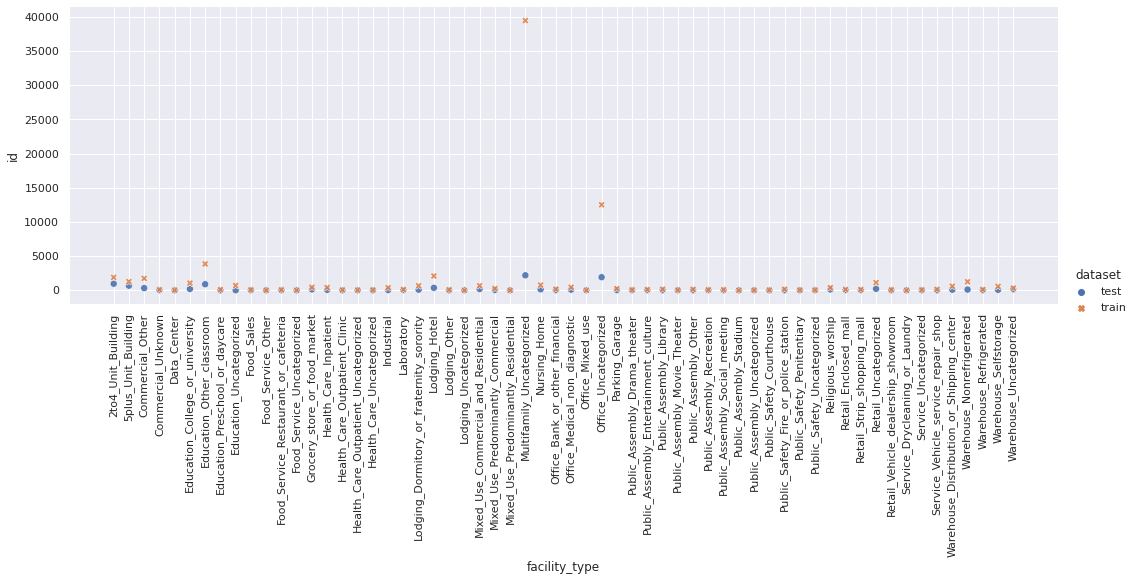

In [ ]:
plt.figure(figsize=(15,7))
sns.relplot(x='facility_type', 
                 y='id', 
                 data=dataset.groupby(['dataset','facility_type']).agg({'id':'count'}).reset_index(),
                 hue='dataset',
                 style='dataset',
                 aspect=3,
                 height=5,
                 s=50,
                 alpha=0.9
                )
plt.xticks(rotation=90)
plt.show()

Major contribution is from "MultiFamily_Uncategorized" and "Office_Uncategorized"

In [ ]:
print(pd.DataFrame(dataset["year_built"].value_counts()))
print(f"Oldest Building is in {dataset[dataset.year_built != 0].year_built.min()}")
print(f"Number of Building in the oldest year:\n {dataset[dataset.year_built == dataset[dataset.year_built != 0].year_built.min()].year_built.value_counts()}\n")
print(f"Newest Building is in {dataset.year_built.max()}")
print(f"Number of Building in the Newest year:\n {dataset[dataset.year_built==dataset.year_built.max()].year_built.value_counts()}")

        year_built
1927.0        2184
1929.0        2141
1928.0        2125
1930.0        1937
1925.0        1864
...            ...
1878.0           1
1732.0           1
1829.0           1
1858.0           1
1840.0           1

[183 rows x 1 columns]
Oldest Building is in 1600.0
Number of Building in the oldest year:
 1600.0    6
Name: year_built, dtype: int64

Newest Building is in 2016.0
Number of Building in the Newest year:
 2016.0    87
Name: year_built, dtype: int64


There are total 183 different years. 

Oldest building is of 1600 and Newest Building is of 2016.

In [ ]:
dataset['year_built'].isna().sum()

1929

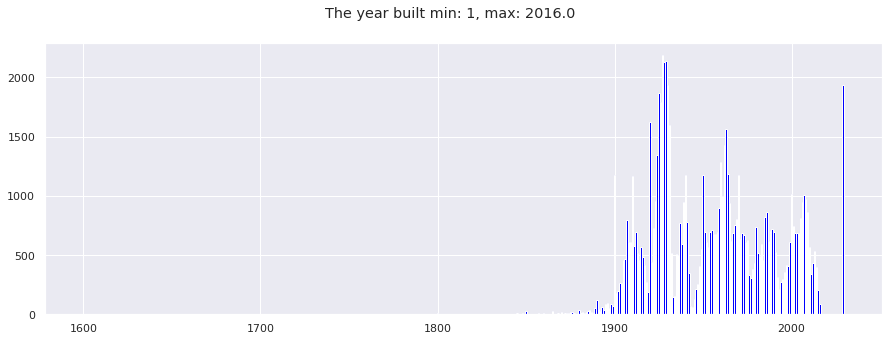

In [ ]:
temp=dataset["year_built"].fillna(2029).replace({0:2029}).astype('category').value_counts().reset_index().rename({0:'count'},axis=1).sort_values('index')

fig, ax = plt.subplots(figsize=(15,5))

ax=plt.bar(temp['index'],
               temp['year_built'],color='blue'
          )

fig.suptitle(f"The year built min: {min(temp['year_built'])}, max: {max(dataset['year_built'])}");

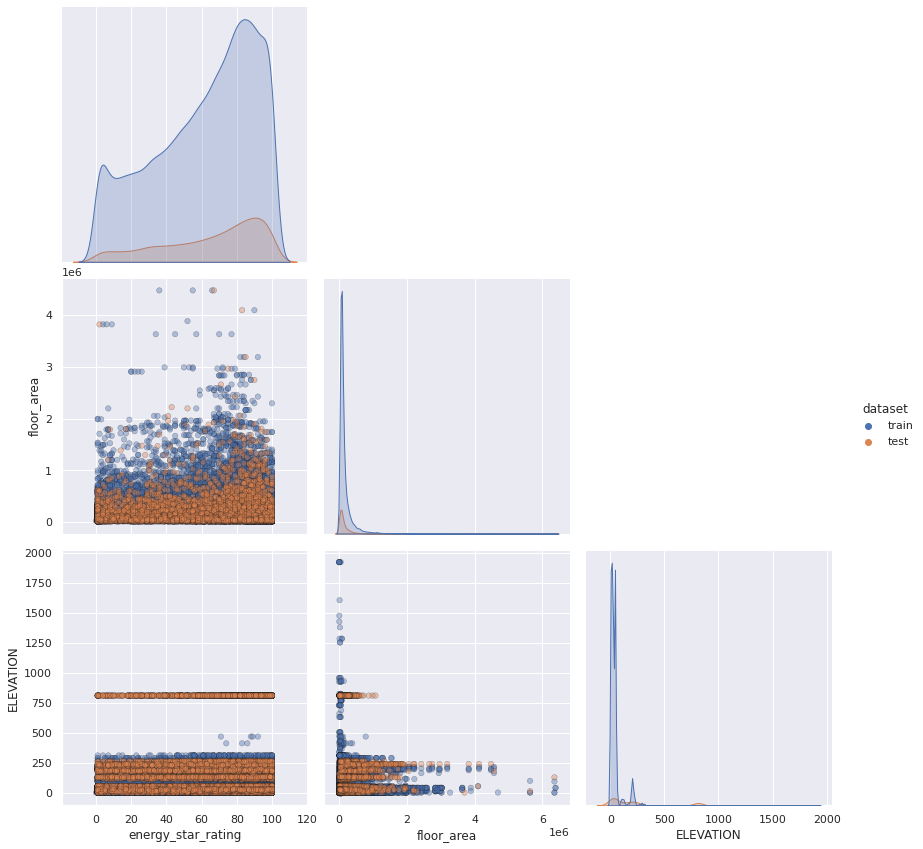

In [ ]:
sns.pairplot(dataset,
            vars=['energy_star_rating','floor_area','ELEVATION'], 
            hue='dataset',
            height=4,
            plot_kws = {'alpha': 0.4, 's': 30, 'edgecolor': 'k'},
            corner=True
           );

`train` set buildings have higher floor areas compared to `test` set buildings and small positive correlation between `floor_area` and `energy_star_rating` can be observable. 

In [ ]:
dataset.columns

Index(['Year_Factor', 'State_Factor', 'building_class', 'facility_type',
       'floor_area', 'year_built', 'energy_star_rating', 'ELEVATION',
       'january_min_temp', 'january_avg_temp', 'january_max_temp',
       'february_min_temp', 'february_avg_temp', 'february_max_temp',
       'march_min_temp', 'march_avg_temp', 'march_max_temp', 'april_min_temp',
       'april_avg_temp', 'april_max_temp', 'may_min_temp', 'may_avg_temp',
       'may_max_temp', 'june_min_temp', 'june_avg_temp', 'june_max_temp',
       'july_min_temp', 'july_avg_temp', 'july_max_temp', 'august_min_temp',
       'august_avg_temp', 'august_max_temp', 'september_min_temp',
       'september_avg_temp', 'september_max_temp', 'october_min_temp',
       'october_avg_temp', 'october_max_temp', 'november_min_temp',
       'november_avg_temp', 'november_max_temp', 'december_min_temp',
       'december_avg_temp', 'december_max_temp', 'cooling_degree_days',
       'heating_degree_days', 'precipitation_inches', 'snowfall_inc

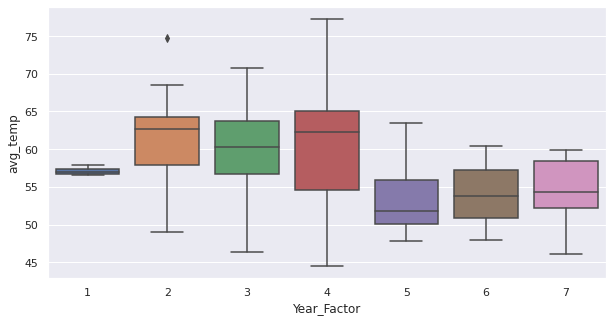

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(data=dataset[['avg_temp','Year_Factor']].drop_duplicates(), y='avg_temp', x='Year_Factor');


Year_Factor-4 has the highest range of the `avg_temp`

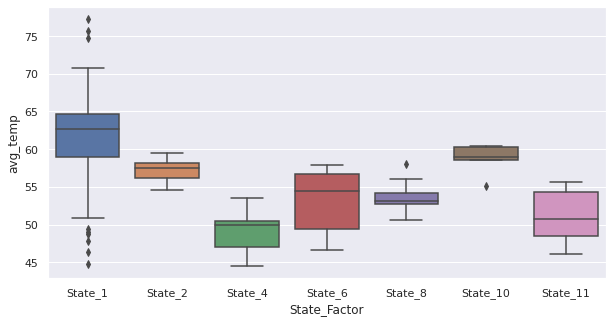

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(data=dataset[['avg_temp','State_Factor']].drop_duplicates(), y='avg_temp', x='State_Factor');


According to the average temperature (`avg_temp`), if we list states from warmest to coldest: State 1, State 10, State 2, and State 8. The range of temperatures of State1, State 6,  State 11 and State 4 are higher compared to the other states. 

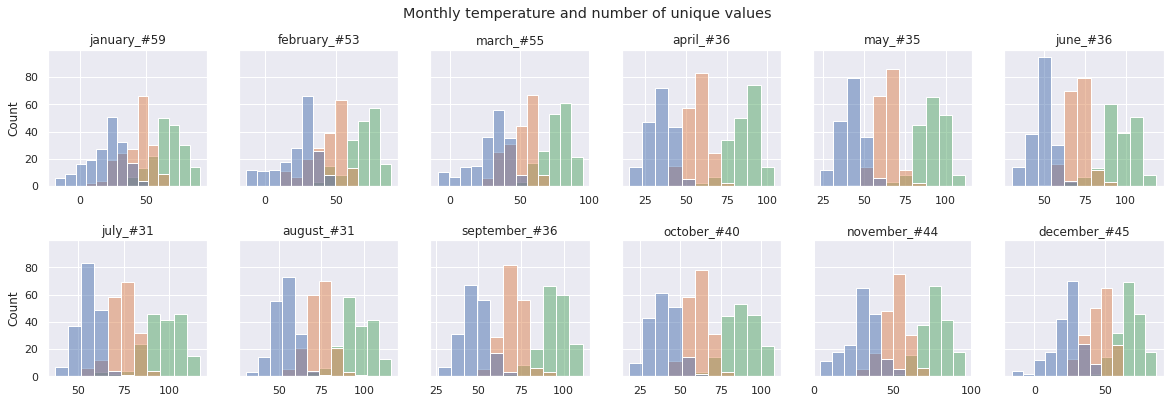

In [ ]:
cols = [['january_min_temp', 'january_avg_temp', 'january_max_temp'],
        ['february_min_temp', 'february_avg_temp', 'february_max_temp'],
        ['march_min_temp', 'march_avg_temp', 'march_max_temp'], 
        ['april_min_temp','april_avg_temp', 'april_max_temp'], 
        ['may_min_temp', 'may_avg_temp','may_max_temp'], 
        ['june_min_temp', 'june_avg_temp', 'june_max_temp'],
        ['july_min_temp', 'july_avg_temp', 'july_max_temp'], 
        ['august_min_temp','august_avg_temp', 'august_max_temp'], 
        ['september_min_temp','september_avg_temp', 'september_max_temp'], 
        ['october_min_temp','october_avg_temp', 'october_max_temp'], 
        ['november_min_temp','november_avg_temp', 'november_max_temp'], 
        ['december_min_temp','december_avg_temp', 'december_max_temp']]

fig, ax = plt.subplots(2, 6, figsize=(20,6), sharey=True)
fig.suptitle("Monthly temperature and number of unique values")

for e, c in enumerate(cols):
    if e<=5:
        sns.histplot(dataset[c].drop_duplicates(), ax=ax[0,e], legend=False)\
        .set(title=c[0][:c[0].find('_')]+ '_#'+str(len(dataset[c[0]].unique())))
    else:
        sns.histplot(dataset[c].drop_duplicates(), ax=ax[1,e-6], legend=False)\
        .set(title=c[0][:c[0].find('_')]+ '_#'+str(len(dataset[c[0]].unique())))
        
plt.subplots_adjust(hspace=0.4)

Each month has unique temperature values between 31 and 59 which means the values in temperature volumes are highly repeated for the data points.

### Target Variable Exploration (EUI)

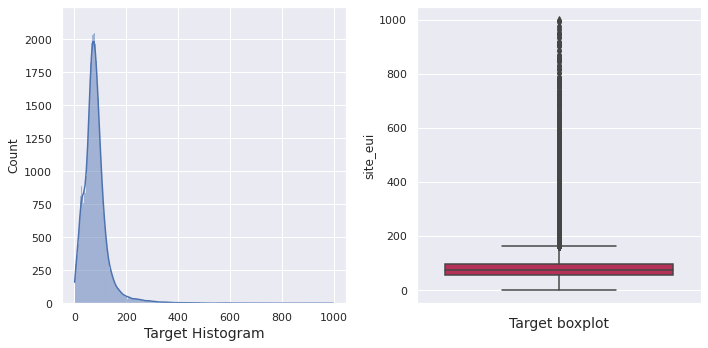

In [ ]:
plt.figure(figsize=(10,5))
ax1 = plt.subplot(1,2,1)
cp = sns.histplot(x=dataset['site_eui'], kde=True, palette='rocket')
ax1.set_xlabel('Target Histogram', fontsize=14)
ax2=plt.subplot(1,2,2)
sns.boxplot(y=dataset['site_eui'],palette='rocket')
ax2.set_xlabel('Target boxplot', fontsize=14)
plt.tight_layout();

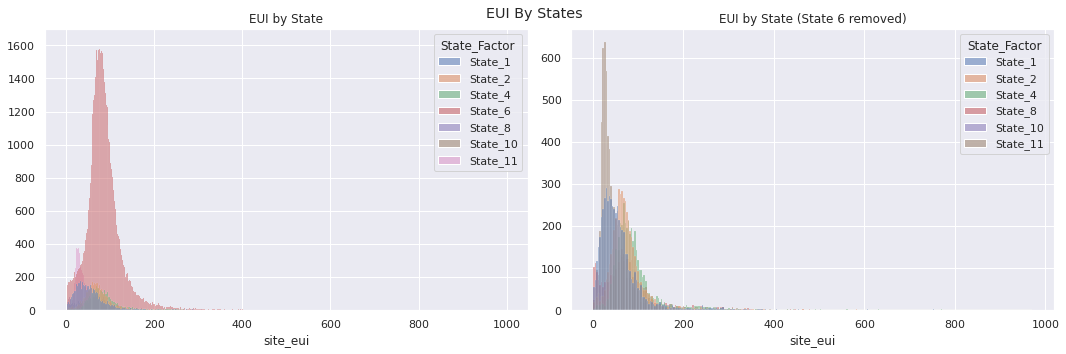

In [ ]:
fig=plt.figure(figsize=(15,5))
ax1=plt.subplot(1,2,1)
fig.suptitle("EUI By States")
sns.histplot(dataset, x='site_eui',hue='State_Factor',ax=ax1)
ax1.set(title='EUI by State', ylabel=None)
ax2=plt.subplot(1,2,2)
sns.histplot(dataset[dataset['State_Factor']!='State_6'], x='site_eui', hue='State_Factor', ax=ax2)
ax2.set(title='EUI by State (State 6 removed)', ylabel=None);
plt.tight_layout();

State_6 has higher EUI.
But when State_6 is removed we get see that state_11 and state_8 are having lower EUI and state_1,state_2 and state_4 have higher EUI

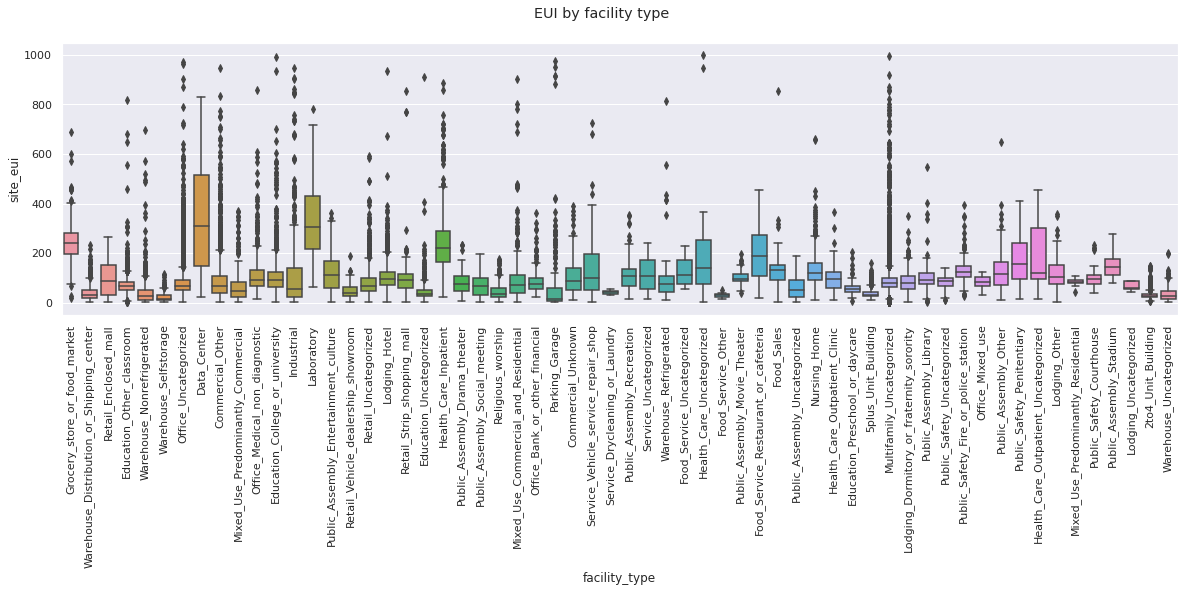

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))
fig.suptitle("EUI by facility type")
ax=sns.boxplot(data=dataset, y='site_eui', x='facility_type')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

Data_Center,Laboratory, Health_Care_Impatient, Service_vehicle_service_repair_shop, Health_care_Uncategorized, Food_service_restaurant_or_cafeteria, Public_safety_Penitentiary and health_care_outpatient_uncategorized are the few facility type buildings which have highest range of EUI.


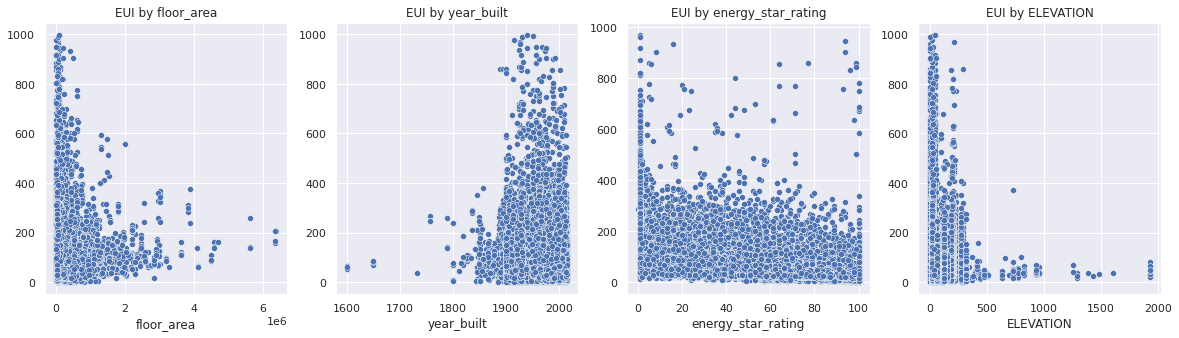

In [ ]:
fig, ax = plt.subplots(1,4, figsize=(20,5))

for e, col in enumerate(['floor_area', 'year_built', 'energy_star_rating', 'ELEVATION']):
    if col =='year_built':
        sns.scatterplot(data=dataset[(dataset['year_built']!=0) & dataset['year_built'].notna()], 
                        x=col, y='site_eui', ax=ax[e]).set(title='EUI by '+ col, ylabel=None)
    else:
        sns.scatterplot(data=dataset, x=col, y='site_eui', ax=ax[e]).set(title='EUI by '+ col, ylabel=None);

`floor_area` could have positive relationship with `EUI`. The younger buildings tend to have higher `EUI` which could be because building height and size have increased over the years. It looks like the Higher the `energy_star_rating` is, the lower the `EUI` becomes.

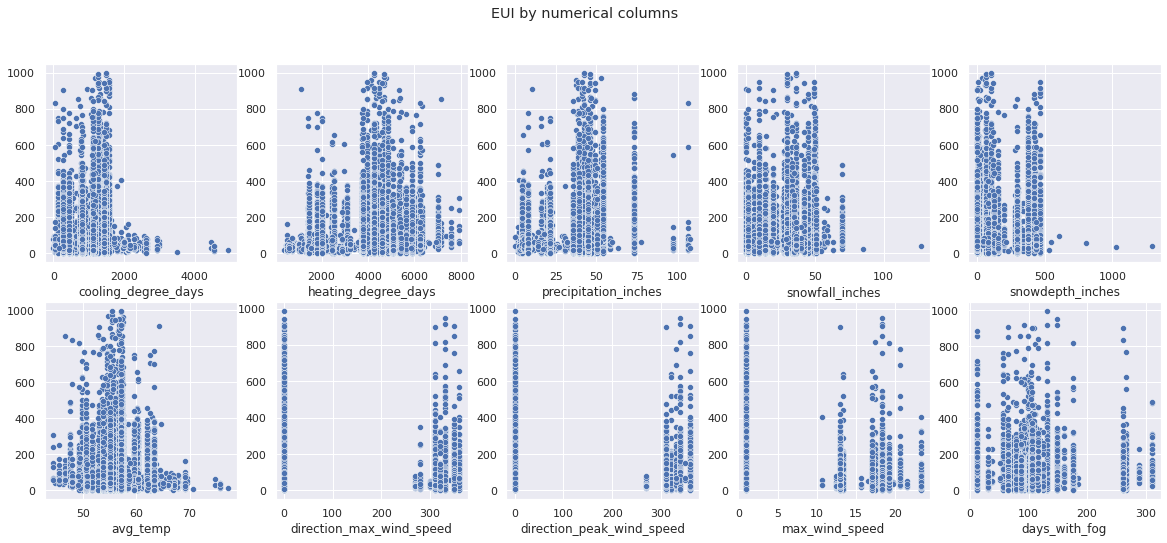

In [ ]:
cols=[['cooling_degree_days','heating_degree_days', 'precipitation_inches', 
      'snowfall_inches','snowdepth_inches'], 
      ['avg_temp', 
      'direction_max_wind_speed','direction_peak_wind_speed', 'max_wind_speed', 
      'days_with_fog']]

fig, ax = plt.subplots(2,5, figsize=(20,8))
fig.suptitle('EUI by numerical columns')

for e1, l in enumerate(cols):
    for e2, col in enumerate(l):
        sns.scatterplot(data=dataset,x=col, y='site_eui', ax=ax[e1, e2]).set(ylabel=None);

The most data points are in lower number of `cooling_degree_days` and higher number of`heating_degree_days`. The majority of the datapoints are also in the lower levels of `snowfall_inches` and `snowdepth_inches`. `direction_max_wind_speed`, `direction_peak_wind_speed`, `max_wind_speed`, and `days_with_fog` columns have the `NA` values of over 50%. No relationship between `EUI` and the weather related numerica columns can be observed from the plot.

## Preprocessing

In [ ]:
groupby_cols = ['State_Factor','building_class','facility_type','floor_area','year_built']
dataset = dataset.sort_values(by=groupby_cols+['Year_Factor']).reset_index(drop=True)


In [ ]:
dataset.head()


,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id,dataset
0,3,State_1,Commercial,Commercial_Other,10149.0,1931.0,NaN,45.7,26,44.516129,...,31,5,0,NaN,NaN,NaN,NaN,6.800000,1456,train
1,4,State_1,Commercial,Commercial_Other,10149.0,1931.0,NaN,120.4,41,55.096774,...,6,0,0,NaN,NaN,NaN,NaN,8.200000,2673,train
2,5,State_1,Commercial,Commercial_Other,10149.0,1931.0,NaN,59.1,29,51.387097,...,52,10,0,NaN,NaN,NaN,NaN,12.300000,3769,train
3,7,State_1,Commercial,Commercial_Other,10149.0,1931.0,NaN,59.1,38,50.596774,...,5,2,0,NaN,NaN,NaN,NaN,NaN,76077,test
4,3,State_1,Commercial,Commercial_Other,10755.0,1937.0,NaN,9.1,22,44.790323,...,10,0,0,NaN,NaN,NaN,NaN,63.083288,2144,train


In [ ]:
print(dataset.shape)

(85462, 65)


In [ ]:
dataset.loc[:,dataset.dtypes=='object'].columns

Index(['State_Factor', 'building_class', 'facility_type', 'dataset'], dtype='object')

Null imputation for categorical values: **KNN Imputing**



In [ ]:
category_columns=['State_Factor', 'building_class', 'facility_type']
for col in category_columns:
  dummies=pd.get_dummies(dataset[col],dummy_na=False)
  for sub_col in dummies:
    dataset[f'{col}_{sub_col}']=dummies[sub_col]

In [ ]:
dataset

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,facility_type_Retail_Uncategorized,facility_type_Retail_Vehicle_dealership_showroom,facility_type_Service_Drycleaning_or_Laundry,facility_type_Service_Uncategorized,facility_type_Service_Vehicle_service_repair_shop,facility_type_Warehouse_Distribution_or_Shipping_center,facility_type_Warehouse_Nonrefrigerated,facility_type_Warehouse_Refrigerated,facility_type_Warehouse_Selfstorage,facility_type_Warehouse_Uncategorized
0,3,State_1,Commercial,Commercial_Other,10149.0,1931.0,NaN,45.7,26,44.516129,...,0,0,0,0,0,0,0,0,0,0
1,4,State_1,Commercial,Commercial_Other,10149.0,1931.0,NaN,120.4,41,55.096774,...,0,0,0,0,0,0,0,0,0,0
2,5,State_1,Commercial,Commercial_Other,10149.0,1931.0,NaN,59.1,29,51.387097,...,0,0,0,0,0,0,0,0,0,0
3,7,State_1,Commercial,Commercial_Other,10149.0,1931.0,NaN,59.1,38,50.596774,...,0,0,0,0,0,0,0,0,0,0
4,3,State_1,Commercial,Commercial_Other,10755.0,1937.0,NaN,9.1,22,44.790323,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85457,7,State_8,Residential,Multifamily_Uncategorized,900000.0,1960.0,90.0,130.8,2,33.435484,...,0,0,0,0,0,0,0,0,0,0
85458,6,State_8,Residential,Multifamily_Uncategorized,1179072.0,1959.0,96.0,3.0,8,29.827586,...,0,0,0,0,0,0,0,0,0,0
85459,7,State_8,Residential,Multifamily_Uncategorized,1179072.0,1959.0,92.0,130.8,2,33.435484,...,0,0,0,0,0,0,0,0,0,0
85460,6,State_8,Residential,Multifamily_Uncategorized,1195034.0,1964.0,75.0,3.0,8,29.827586,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# This takes 1 hr, hence, unpickle the df1 and carry on with knn_imputing = False
knn_imputing = False
target='site_eui'

if knn_imputing:
    imputer = KNNImputer(n_neighbors=7)
    tmp = dataset[['State_Factor', 'building_class', 'facility_type', 'dataset', target]]
    df = dataset.drop(tmp.columns, axis=1)
    df1 = pd.DataFrame(imputer.fit_transform(df),columns = df.columns)
    
    tmp.to_csv('/content/drive/MyDrive/Site_Energy_Intensity_Prediction/Dataset/imputer_tmp.csv', index=False)
    df1.to_csv('/content/drive/MyDrive/Site_Energy_Intensity_Prediction/Dataset/imputer_df1.csv', index=False)
    joblib.dump(imputer, '/content/drive/MyDrive/Site_Energy_Intensity_Prediction/Model/knn_imputer.pkl')

else:
    df1 = pd.read_csv('/content/drive/MyDrive/Site_Energy_Intensity_Prediction/Dataset/imputer_df1.csv')
    tmp = dataset[['State_Factor', 'building_class', 'facility_type', 'dataset', target]]
    dataset_all = dataset.drop(tmp.columns, axis=1)
    
    for col in tmp.columns:
        dataset_all[col]=tmp[col]
    for col in df1.columns:
        dataset_all[col] = df1[col]

In [ ]:
# for col in ['State_Factor', 'building_class', 'facility_type', 'dataset']:
#   dataset[col].fillna(dataset[col].mode()[0])

In [ ]:
cats = ['State_Factor', 'building_class', 'facility_type']
target='site_eui'
for col in cats:
    encoder = TargetEncoder()
    dataset[f'te_{col}'] = encoder.fit_transform(dataset[col], dataset[target])

/usr/local/lib/python3.7/dist-packages/category_encoders/target_encoder.py:94: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/category_encoders/target_encoder.py:99: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)


## Feature Engineering

In [ ]:
# extract new weather statistics from the building location weather features
temp = [col for col in dataset.columns if 'temp' in col]

dataset['min_temp'] = dataset[temp].min(axis=1)
dataset['max_temp'] = dataset[temp].max(axis=1)
dataset['avg_temp'] = dataset[temp].mean(axis=1)
dataset['std_temp'] = dataset[temp].std(axis=1)
dataset['skew_temp'] = dataset[temp].skew(axis=1)


# by seasons
temp = pd.Series([col for col in dataset.columns if 'temp' in col])

winter_temp = temp[temp.apply(lambda x: ('january' in x or 'february' in x or 'december' in x))].values
spring_temp = temp[temp.apply(lambda x: ('march' in x or 'april' in x or 'may' in x))].values
summer_temp = temp[temp.apply(lambda x: ('june' in x or 'july' in x or 'august' in x))].values
autumn_temp = temp[temp.apply(lambda x: ('september' in x or 'october' in x or 'november' in x))].values


### winter
dataset['min_winter_temp'] = dataset[winter_temp].min(axis=1)
dataset['max_winter_temp'] = dataset[winter_temp].max(axis=1)
dataset['avg_winter_temp'] = dataset[winter_temp].mean(axis=1)
dataset['std_winter_temp'] = dataset[winter_temp].std(axis=1)
dataset['skew_winter_temp'] =dataset[winter_temp].skew(axis=1)
### spring
dataset['min_spring_temp'] = dataset[spring_temp].min(axis=1)
dataset['max_spring_temp'] = dataset[spring_temp].max(axis=1)
dataset['avg_spring_temp'] = dataset[spring_temp].mean(axis=1)
dataset['std_spring_temp'] = dataset[spring_temp].std(axis=1)
dataset['skew_spring_temp'] =dataset[spring_temp].skew(axis=1)
### summer
dataset['min_summer_temp'] = dataset[summer_temp].min(axis=1)
dataset['max_summer_temp'] = dataset[summer_temp].max(axis=1)
dataset['avg_summer_temp'] = dataset[summer_temp].mean(axis=1)
dataset['std_summer_temp'] = dataset[summer_temp].max(axis=1)
dataset['skew_summer_temp'] =dataset[summer_temp].max(axis=1)
## autumn
dataset['min_autumn_temp'] = dataset[autumn_temp].min(axis=1)
dataset['max_autumn_temp'] = dataset[autumn_temp].max(axis=1)
dataset['avg_autumn_temp'] = dataset[autumn_temp].mean(axis=1)
dataset['std_autumn_temp'] = dataset[autumn_temp].std(axis=1)
dataset['skew_autumn_temp'] = dataset[autumn_temp].skew(axis=1)

In [ ]:
dataset['month_cooling_degree_days'] = dataset['cooling_degree_days']/12
dataset['month_heating_degree_days'] = dataset['heating_degree_days']/12

### Buildig based feature:

we will extract building statistics

In [ ]:
# total area
dataset['building_area'] = dataset['floor_area'] * dataset['ELEVATION']
# rating energy by floor
dataset['floor_energy_star_rating'] = dataset['energy_star_rating']/dataset['ELEVATION']

### Checking target variable transformation

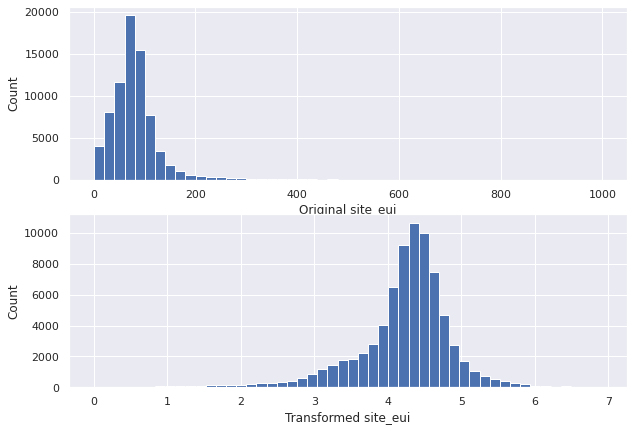

In [ ]:
target = 'site_eui'
plt.figure(figsize=(10,7))
# plot the original variable vs sale price    
plt.subplot(2, 1, 1)
train[target].hist(bins=50)
plt.ylabel('Count')
plt.xlabel('Original ' + target)

# plot transformed variable vs sale price
plt.subplot(2, 1, 2)
np.log(train[target]).hist(bins=50)
plt.ylabel('Count')
plt.xlabel('Transformed ' + target);

In [ ]:
nums = train.loc[:, train.dtypes != 'object'].columns
dataset[nums].hist(bins=50, figsize=(20,20))
plt.show();

In [ ]:
dataset[nums].skew().sort_values(key=abs, ascending=False)[:5]

Binarize very skewed variables

In [ ]:
skewed = ['days_above_110F', 'days_above_100F']

for var in skewed:
    
    # map the variable values into 0 and 1
    dataset[var] = np.where(dataset[var]==0, 0, 1)

### Saving feature dataset

In [ ]:
saved = False
if saved:
    !pip install pickle5 --quiet
    import pickle5 as pickle
    data_path = '/content/drive/MyDrive/Site_Energy_Intensity_Prediction/Dataset/feature_transformed_set.pkl'
    with open(data_path, "rb") as fh:
        dataset = pickle.load(fh)
else:
    dataset.to_pickle('/content/drive/MyDrive/Site_Energy_Intensity_Prediction/Dataset/feature_transformed_set.pkl')

In [ ]:
dataset.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,skew_summer_temp,min_autumn_temp,max_autumn_temp,avg_autumn_temp,std_autumn_temp,skew_autumn_temp,month_cooling_degree_days,month_heating_degree_days,building_area,floor_energy_star_rating
0,3,State_1,Commercial,Commercial_Other,10149.0,1931.0,NaN,45.7,26,44.516129,...,104.0,36.0,98.0,63.361111,20.462133,0.360253,68.833333,211.833333,463809.3,NaN
1,4,State_1,Commercial,Commercial_Other,10149.0,1931.0,NaN,120.4,41,55.096774,...,90.0,46.0,95.0,67.521625,15.342943,0.494753,41.416667,123.083333,1221939.6,NaN
2,5,State_1,Commercial,Commercial_Other,10149.0,1931.0,NaN,59.1,29,51.387097,...,106.0,29.0,105.0,67.003405,23.881873,0.162329,109.916667,151.916667,599805.9,NaN
3,7,State_1,Commercial,Commercial_Other,10149.0,1931.0,NaN,59.1,38,50.596774,...,97.0,43.0,104.0,66.778913,19.843743,0.883927,28.500000,176.000000,599805.9,NaN
4,3,State_1,Commercial,Commercial_Other,10755.0,1937.0,NaN,9.1,22,44.790323,...,99.0,31.0,96.0,60.048268,22.548770,0.276234,25.250000,259.000000,97870.5,NaN


In [ ]:
dataset.shape

(85462, 165)

## Baseline Modelling

In [ ]:
cats = ['State_Factor', 'facility_type', 'building_class', 'days_above_100F', 'days_above_110F']

# typecasting numerical features
for col in dataset.drop(columns=cats + ['dataset', 'id', 'site_eui']).columns:
    dataset[col] = dataset[col].astype('float64')

In [ ]:
dataset.drop(columns=cats)

,Year_Factor,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,...,skew_summer_temp,min_autumn_temp,max_autumn_temp,avg_autumn_temp,std_autumn_temp,skew_autumn_temp,month_cooling_degree_days,month_heating_degree_days,building_area,floor_energy_star_rating
0,3.0,10149.0,1931.0,NaN,45.7,26.0,44.516129,64.0,30.0,49.392857,...,104.0,36.0,98.0,63.361111,20.462133,0.360253,68.833333,211.833333,463809.3,NaN
1,4.0,10149.0,1931.0,NaN,120.4,41.0,55.096774,73.0,42.0,54.875000,...,90.0,46.0,95.0,67.521625,15.342943,0.494753,41.416667,123.083333,1221939.6,NaN
2,5.0,10149.0,1931.0,NaN,59.1,29.0,51.387097,77.0,36.0,56.803571,...,106.0,29.0,105.0,67.003405,23.881873,0.162329,109.916667,151.916667,599805.9,NaN
3,7.0,10149.0,1931.0,NaN,59.1,38.0,50.596774,64.0,40.0,54.482143,...,97.0,43.0,104.0,66.778913,19.843743,0.883927,28.500000,176.000000,599805.9,NaN
4,3.0,10755.0,1937.0,NaN,9.1,22.0,44.790323,65.0,25.0,47.892857,...,99.0,31.0,96.0,60.048268,22.548770,0.276234,25.250000,259.000000,97870.5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85457,7.0,900000.0,1960.0,90.0,130.8,2.0,33.435484,61.0,16.0,37.660714,...,91.0,17.0,91.0,55.995818,24.752362,-0.095805,72.166667,438.666667,117720000.0,0.688073
85458,6.0,1179072.0,1959.0,96.0,3.0,8.0,29.827586,62.0,4.0,33.896552,...,96.0,20.0,96.0,55.974970,26.286606,0.078569,92.833333,422.833333,3537216.0,32.000000
85459,7.0,1179072.0,1959.0,92.0,130.8,2.0,33.435484,61.0,16.0,37.660714,...,91.0,17.0,91.0,55.995818,24.752362,-0.095805,72.166667,438.666667,154222617.6,0.703364
85460,6.0,1195034.0,1964.0,75.0,3.0,8.0,29.827586,62.0,4.0,33.896552,...,96.0,20.0,96.0,55.974970,26.286606,0.078569,92.833333,422.833333,3585102.0,25.000000


In [ ]:
train = dataset[dataset['dataset']=='train']
test = dataset[dataset['dataset']=='test']

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

test_ids = test['id']
train_ids = train['id']

target = train['site_eui'] #y_train

train = train.drop(['id', 'dataset', 'site_eui'], axis=1) #X_train
test = test.drop(['id', 'dataset', 'site_eui'], axis=1) #X_test

### Label Encoding discrete features

In [ ]:
# get discrete end categorical features colums indexes 
# needed later for the cat bosst model
cats_discrete_idx = np.where(train.dtypes != 'float64')[0]
# create the label
le = LabelEncoder()
for col_idx in cats_discrete_idx:
    train.iloc[:, col_idx] = le.fit_transform(train.iloc[:, col_idx].astype(str))
    test.iloc[:, col_idx] = le.transform(test.iloc[:, col_idx].astype(str))

In [ ]:
print("Label Encoded Columns:")
for i in cats_discrete_idx:
    print(train.columns[i])

Label Encoded Columns:
State_Factor
building_class
facility_type
days_above_100F
days_above_110F


In [ ]:
y_test = pd.read_csv('/content/drive/MyDrive/Site_Energy_Intensity_Prediction/Dataset/y_test.csv')

X_train = train
X_test = test
y_train = target
y_test = y_test['site_eui']
print('Train: ', X_train.shape)
print('Test:', X_test.shape)
print('Samples: ', y_train.shape)
print('Targets: ', y_test.shape)

Train:  (75757, 162)
Test: (9705, 162)
Samples:  (75757,)
Targets:  (9705,)


In [ ]:
error_rec = {}

### Catboost

In [ ]:
catb = CatBoostRegressor(iterations=500,
                         learning_rate=0.02,
                         depth=12,
                         eval_metric='RMSE',
#                         early_stopping_rounds=42,
                         random_seed = 23,
                         bagging_temperature = 0.2,
                         od_type='Iter',
                         metric_period = 75,
                         od_wait=100)

In [ ]:
catb.fit(X_train, y_train,
                 eval_set=(X_test,y_test),
                 cat_features=cats_discrete_idx,
                 use_best_model=True,
                 verbose=True)

y_pred = catb.predict(X_test)

0:	learn: 57.8394640	test: 61.1789995	best: 61.1789995 (0)	total: 663ms	remaining: 5m 30s
75:	learn: 44.5895022	test: 68.8735572	best: 61.1789995 (0)	total: 46.5s	remaining: 4m 19s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 61.17899951
bestIteration = 0

Shrink model to first 1 iterations.


In [ ]:
print(" Training data scores\n","--"*10)
error_rec["catboost"]={"rmse":np.sqrt(mean_squared_error(y_test,y_pred)),"mae":mean_absolute_error(y_test,y_pred)}
print(" RMSE:", np.sqrt(mean_squared_error(y_test,y_pred)))
print(" MAE:", mean_absolute_error(y_test,y_pred))
print(" MSE:", mean_squared_error(y_test,y_pred))
print(" R2:", r2_score(y_test,y_pred))

 Training data scores
 --------------------
 RMSE: 61.178999536497386
 MAE: 40.256957319399284
 MSE: 3742.8699842867472
 R2: -0.03517804667173485


### XGBoost

In [ ]:
xgb = XGBRegressor(n_estimators=500, reg_alpha=0.01, n_jobs=-1)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

[14:08:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
print(" Training data scores\n","--"*10)
error_rec["xgboost"]={"rmse":np.sqrt(mean_squared_error(y_test,y_pred)),"mae":mean_absolute_error(y_test,y_pred)}
print(" RMSE:", np.sqrt(mean_squared_error(y_test,y_pred)))
print(" MAE:", mean_absolute_error(y_test,y_pred))
print(" MSE:", mean_squared_error(y_test,y_pred))
print(" R2:", r2_score(y_test,y_pred))

 Training data scores
 --------------------
 RMSE: 78.47219897813784
 MAE: 51.46206487107113
 MSE: 6157.886012464458
 R2: -0.7031070918229883


### RandomForest

In [ ]:
pd.DataFrame(dataset.describe()).to_csv("/content/drive/MyDrive/Site_Energy_Intensity_Prediction/Dataset/describe.csv")

In [ ]:
describe=pd.read_csv("/content/drive/MyDrive/Site_Energy_Intensity_Prediction/Dataset/describe.csv")


In [ ]:
rf = RandomForestRegressor(random_state=2, criterion='mse', max_depth = 15, min_samples_split= 2)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

ValueError: ignored

In [ ]:
# print(" Training data scores\n","--"*10)
# error_rec["rfr"]={"rmse":np.sqrt(mean_squared_error(y_test,y_pred)),"mae":mean_absolute_error(y_test,y_pred)}
# print(" RMSE:", np.sqrt(mean_squared_error(y_test,y_pred)))
# print(" MAE:", mean_absolute_error(y_test,y_pred))
# print(" MSE:", mean_squared_error(y_test,y_pred))
# print(" R2:", r2_score(y_test,y_pred))

## Model Evaluation

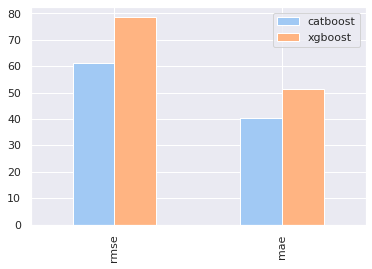

In [ ]:
pd.DataFrame(error_rec).plot(kind="bar", 
             color=[
                 sns.color_palette("pastel")[0], 
                 sns.color_palette("pastel")[1], 
                 sns.color_palette("pastel")[2], 
                 sns.color_palette("pastel")[3]]);

### Using CrossValidation on CatBoost

In [ ]:
# prepaere the out of folds predictions 
train_oof = np.zeros((train.shape[0],))
test_preds = np.zeros(test.shape[0])

NUM_FOLDS = 5
kf = KFold(n_splits=5, shuffle=True, random_state=0)


for fold, (train_idx, test_idx) in tqdm.tqdm(enumerate(kf.split(train, target))):
    X_train, X_test = train.iloc[train_idx][test.columns], train.iloc[test_idx][test.columns]
    y_train, y_test = target[train_idx], target[test_idx]
    
    catb = CatBoostRegressor(iterations=500,
                         learning_rate=0.02,
                         depth=12,
                         eval_metric='RMSE',
#                         early_stopping_rounds=42,
                         random_seed = 23,
                         bagging_temperature = 0.2,
                         od_type='Iter',
                         metric_period = 75,
                         od_wait=100)
    # train model
    catb.fit(X_train, y_train,
                 eval_set=(X_test,y_test),
                 cat_features=cats_discrete_idx,
                 use_best_model=True,
                 verbose=True)

    oof = catb.predict(X_test)
    train_oof[test_idx] = oof
    test_preds += catb.predict(test)/NUM_FOLDS      
    print(f"out-of-folds prdiction ==== fold_{fold} RMSE",np.sqrt(mean_squared_error(oof, y_test, squared=False)))


0it [00:00, ?it/s]Warning: Overfitting detector is active, thus evaluation metric is calculated on every iteration. 'metric_period' is ignored for evaluation metric.


0:	learn: 58.1285663	test: 57.0668664	best: 57.0668664 (0)	total: 606ms	remaining: 5m 2s
75:	learn: 45.0222894	test: 44.5430549	best: 44.5430549 (75)	total: 42.2s	remaining: 3m 55s
150:	learn: 41.8962443	test: 42.2405980	best: 42.2405980 (150)	total: 1m 21s	remaining: 3m 7s
225:	learn: 40.5384675	test: 41.5582254	best: 41.5582254 (225)	total: 1m 59s	remaining: 2m 25s
300:	learn: 39.6891638	test: 41.2634204	best: 41.2634204 (300)	total: 2m 40s	remaining: 1m 46s
375:	learn: 39.0322583	test: 41.0592849	best: 41.0592849 (375)	total: 3m 19s	remaining: 1m 5s
450:	learn: 38.4037884	test: 40.8732202	best: 40.8732202 (450)	total: 3m 57s	remaining: 25.9s
499:	learn: 38.0140454	test: 40.7586392	best: 40.7586392 (499)	total: 4m 23s	remaining: 0us

bestTest = 40.75863923
bestIteration = 499



1it [04:24, 264.44s/it]

out-of-folds prdiction ==== fold_0 RMSE 6.384249304082069


0:	learn: 58.0223895	test: 57.4908712	best: 57.4908712 (0)	total: 541ms	remaining: 4m 30s
75:	learn: 44.8458730	test: 45.1023954	best: 45.1023954 (75)	total: 41.3s	remaining: 3m 50s
150:	learn: 41.8124128	test: 42.9116679	best: 42.9116679 (150)	total: 1m 20s	remaining: 3m 5s
225:	learn: 40.4452478	test: 42.2135449	best: 42.2135449 (225)	total: 1m 58s	remaining: 2m 23s
300:	learn: 39.5371585	test: 41.8066161	best: 41.8066161 (300)	total: 2m 36s	remaining: 1m 43s
375:	learn: 38.8178159	test: 41.5592738	best: 41.5579954 (374)	total: 3m 16s	remaining: 1m 4s
450:	learn: 38.1698368	test: 41.3761150	best: 41.3760869 (449)	total: 3m 53s	remaining: 25.4s
499:	learn: 37.7993378	test: 41.2784998	best: 41.2784998 (499)	total: 4m 18s	remaining: 0us

bestTest = 41.27849982
bestIteration = 499



2it [08:43, 261.29s/it]

out-of-folds prdiction ==== fold_1 RMSE 6.424834611725375


0:	learn: 57.7302633	test: 58.6172999	best: 58.6172999 (0)	total: 521ms	remaining: 4m 19s
75:	learn: 44.3025887	test: 47.0932472	best: 47.0932472 (75)	total: 39.4s	remaining: 3m 39s
150:	learn: 41.0921753	test: 45.2636352	best: 45.2636352 (150)	total: 1m 20s	remaining: 3m 5s
225:	learn: 39.6451482	test: 44.7353585	best: 44.7353585 (225)	total: 2m	remaining: 2m 26s
300:	learn: 38.5613557	test: 44.4615685	best: 44.4615685 (300)	total: 2m 40s	remaining: 1m 45s
375:	learn: 37.7864077	test: 44.3044490	best: 44.3044490 (375)	total: 3m 18s	remaining: 1m 5s
450:	learn: 37.0368036	test: 44.1957651	best: 44.1952913 (449)	total: 4m	remaining: 26.1s
499:	learn: 36.6526730	test: 44.1402504	best: 44.1390648 (494)	total: 4m 27s	remaining: 0us

bestTest = 44.1390648
bestIteration = 494

Shrink model to first 495 iterations.


3it [13:11, 264.46s/it]

out-of-folds prdiction ==== fold_2 RMSE 6.643723723040352


0:	learn: 58.4680455	test: 55.3644380	best: 55.3644380 (0)	total: 540ms	remaining: 4m 29s
75:	learn: 44.9213568	test: 43.3400811	best: 43.3400811 (75)	total: 39.3s	remaining: 3m 39s
150:	learn: 41.7083081	test: 41.5339017	best: 41.5339017 (150)	total: 1m 18s	remaining: 3m
225:	learn: 40.2732527	test: 41.0719238	best: 41.0719238 (225)	total: 1m 58s	remaining: 2m 23s
300:	learn: 39.4568120	test: 40.9416449	best: 40.9416449 (300)	total: 2m 38s	remaining: 1m 44s
375:	learn: 38.7509572	test: 40.8386638	best: 40.8369240 (373)	total: 3m 16s	remaining: 1m 4s
450:	learn: 38.1015854	test: 40.6794969	best: 40.6794969 (450)	total: 3m 54s	remaining: 25.5s
499:	learn: 37.7344327	test: 40.6176366	best: 40.6128053 (488)	total: 4m 21s	remaining: 0us

bestTest = 40.61280533
bestIteration = 488

Shrink model to first 489 iterations.


4it [17:34, 263.64s/it]

out-of-folds prdiction ==== fold_3 RMSE 6.372817691294543


0:	learn: 57.0905773	test: 60.8280558	best: 60.8280558 (0)	total: 547ms	remaining: 4m 32s
75:	learn: 44.1307583	test: 48.3851469	best: 48.3851469 (75)	total: 41.5s	remaining: 3m 51s
150:	learn: 41.0648316	test: 45.9247111	best: 45.9247111 (150)	total: 1m 20s	remaining: 3m 6s
225:	learn: 39.6945821	test: 45.1353025	best: 45.1348472 (224)	total: 1m 59s	remaining: 2m 25s
300:	learn: 38.9939225	test: 44.8561177	best: 44.8561177 (300)	total: 2m 39s	remaining: 1m 45s
375:	learn: 38.3116509	test: 44.6185514	best: 44.6173026 (373)	total: 3m 19s	remaining: 1m 5s
450:	learn: 37.8119452	test: 44.4914421	best: 44.4911501 (448)	total: 3m 57s	remaining: 25.8s
499:	learn: 37.4623936	test: 44.3947292	best: 44.3947292 (499)	total: 4m 22s	remaining: 0us

bestTest = 44.39472925
bestIteration = 499



5it [21:57, 263.54s/it]

out-of-folds prdiction ==== fold_4 RMSE 6.662936975787842


### Final Evaluation

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'iteration')

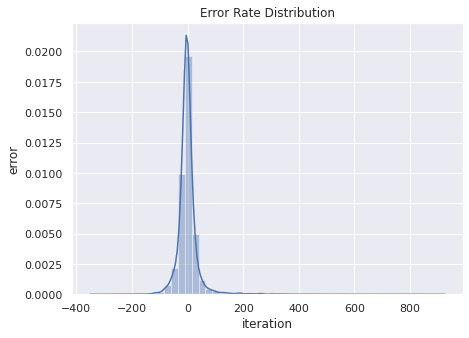

In [ ]:
y_hat_tuned = catb.predict(X_test)

plt.figure(figsize = (7,5))
sns.distplot(y_test - y_hat_tuned)
plt.title("Error Rate Distribution");
plt.ylabel("error")
plt.xlabel("iteration")

In [ ]:
# with open('models/rf_tuned_final.joblib', 'wb') as f:
#     joblib.dump(rf_tuned_model, f, compress=1)

with open('/content/drive/MyDrive/Site_Energy_Intensity_Prediction/Model/catb_best_final.joblib', 'wb') as f:
    joblib.dump(catb,f,compress=3)

In [ ]:
model=joblib.load('/content/drive/MyDrive/Site_Energy_Intensity_Prediction/Model/catb_best_final.joblib')


In [ ]:
y_pred = model.predict(X_test)

In [ ]:
mean_squared_error(y_test,y_pred)

1970.89197570882